In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import feature
from sklearn import metrics
from tensorflow import keras

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

TensorFlow: 2.19.0
Keras: 3.10.0


In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

Train: (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


In [14]:
x_train = x_train[:15000]
y_train = y_train[:15000]
x_test  = x_test[:3000]
y_test  = y_test[:3000]

print("Reduced Train:", x_train.shape)
print("Reduced Test :", x_test.shape)

Reduced Train: (15000, 28, 28)
Reduced Test : (3000, 28, 28)


In [15]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

In [16]:
data_trainHog = []
for i in range(len(x_train)):
    H = feature.hog(
        x_train[i],
        orientations=9,
        pixels_per_cell=(7, 7),
        cells_per_block=(1, 1),
        transform_sqrt=True
    )
    data_trainHog.append(H)

data_trainHog = np.array(data_trainHog)
print("HOG Train shape:", data_trainHog.shape)

data_testHog = []
for i in range(len(x_test)):
    H = feature.hog(
        x_test[i],
        orientations=9,
        pixels_per_cell=(7, 7),
        cells_per_block=(1, 1),
        transform_sqrt=True
    )
    data_testHog.append(H)

data_testHog = np.array(data_testHog)
print("HOG Test shape:", data_testHog.shape)

HOG Train shape: (15000, 144)
HOG Test shape: (3000, 144)


In [17]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius

    def LBPfeatures(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(
            image, self.numPoints, self.radius, method="uniform"
        )
        (hist, _) = np.histogram(
            lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2)
        )
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

In [18]:
obj = LocalBinaryPatterns(24, 8)

data_train_LBP = []
for i in range(len(x_train)):
    hist = obj.LBPfeatures(x_train[i])
    data_train_LBP.append(hist)

data_train_LBP = np.array(data_train_LBP)
print("LBP Train shape:", data_train_LBP.shape)

data_test_LBP = []
for i in range(len(x_test)):
    hist = obj.LBPfeatures(x_test[i])
    data_test_LBP.append(hist)

data_test_LBP = np.array(data_test_LBP)
print("LBP Test shape:", data_test_LBP.shape)

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP Train shape: (15000, 26)
LBP Test shape: (3000, 26)


In [19]:
X_train = np.hstack((data_trainHog, data_train_LBP))
X_test  = np.hstack((data_testHog, data_test_LBP))

print("Combined Train features:", X_train.shape)
print("Combined Test features :", X_test.shape)

Combined Train features: (15000, 170)
Combined Test features : (3000, 170)


In [20]:
valid_size = 2000  # you can change this

X_valid = X_train[:valid_size]
y_valid = y_train[:valid_size]

X_train2 = X_train[valid_size:]
y_train2 = y_train[valid_size:]

print("Train split:", X_train2.shape, y_train2.shape)
print("Valid split:", X_valid.shape, y_valid.shape)

Train split: (13000, 170) (13000,)
Valid split: (2000, 170) (2000,)


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(X_train2.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        43,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,962 (304.54 KB)

 Trainable params: 77,962 (304.54 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    X_train2, y_train2,
    epochs=10,
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7071 - loss: 1.0925 - val_accuracy: 0.9285 - val_loss: 0.2372
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9346 - loss: 0.2089 - val_accuracy: 0.9455 - val_loss: 0.1730
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9505 - loss: 0.1527 - val_accuracy: 0.9355 - val_loss: 0.1913
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9543 - loss: 0.1345 - val_accuracy: 0.9390 - val_loss: 0.1727
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9604 - loss: 0.1141 - val_accuracy: 0.9465 - val_loss: 0.1631
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9650 - loss: 0.1073 - val_accuracy: 0.9440 - val_loss: 0.1612
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9732 - loss: 0.0830 - val_accuracy: 0.9400 - val_loss: 0.1761
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9721 - loss: 0.0782 - val_accuracy: 0

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9537 - loss: 0.1454
Test accuracy: 0.9423333406448364
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


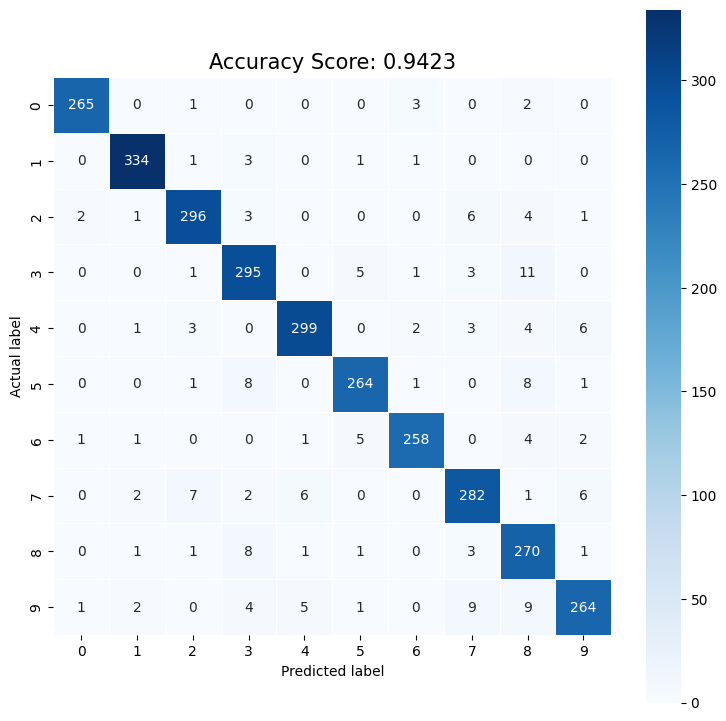

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

pred_probs = model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)

acc_score = metrics.accuracy_score(y_test, pred_labels)
cm = metrics.confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap="Blues")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title(f"Accuracy Score: {acc_score:.4f}", size=15)
plt.show()